###  CONSOLIDATED SCRIPT FOR RUNNING THE HYBRID RETURN RISK MODEL FOR MEESHO

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### MODEL TRAINING

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load training data
train_df = pd.read_csv('data/consolidated_train_dataset.csv')

# Define features and label columns
exclude_cols = ['buyer_id', 'seller', 'region', 'risk_category', 'fraud_label', 'composite_risk_score']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X = train_df[feature_cols]
y = train_df['fraud_label']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

print("Model trained successfully.")


Model trained successfully.


#### MODEL EVALUATION ON TEST DATA

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import os

os.makedirs('results', exist_ok=True)

# Load training and test data
train_df = pd.read_csv('data/consolidated_train_dataset.csv')
test_df = pd.read_csv('data/test_noisy_dataset.csv')

exclude_cols = ['buyer_id', 'seller', 'region', 'risk_category', 'fraud_label', 'composite_risk_score']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df['fraud_label']
X_test = test_df[feature_cols]
y_test = test_df['fraud_label']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

test_df['predicted_label'] = y_pred
test_df['predicted_proba'] = y_prob
test_df.to_csv('results/test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        65
           1       0.94      0.91      0.93        35

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.95      0.95       100

ROC-AUC Score: 0.9408791208791208
Test predictions saved to 'test_predictions.csv'


#### GRAPHS  FOR VISUALIZATION - TRAIN & TEST

#### TRAIN

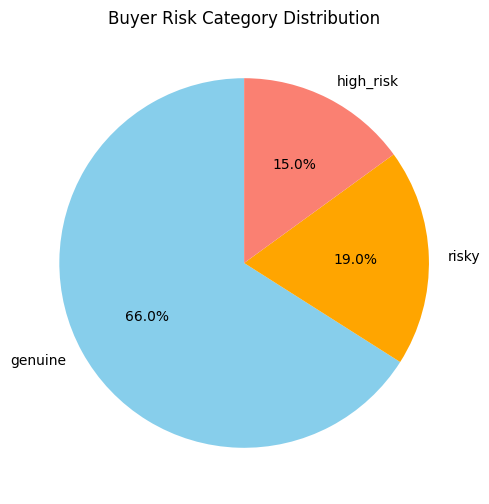

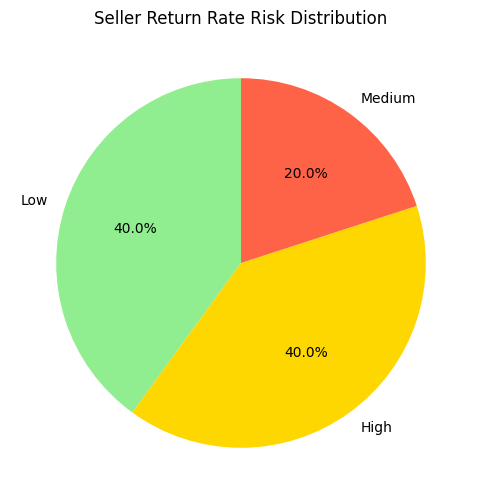

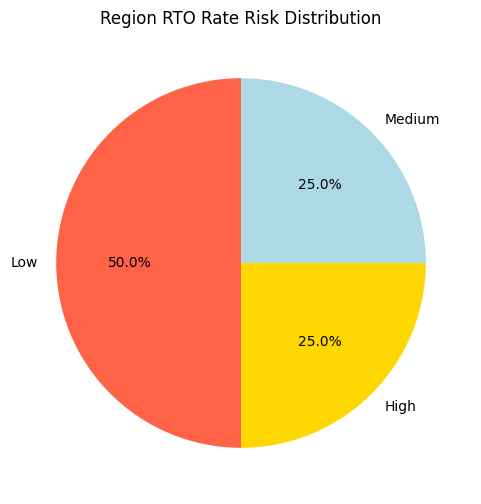

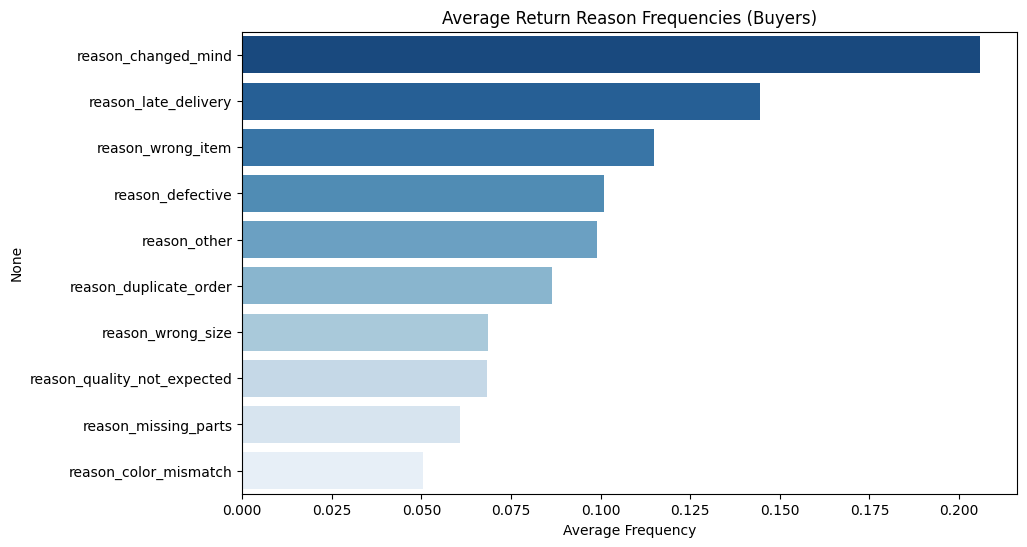

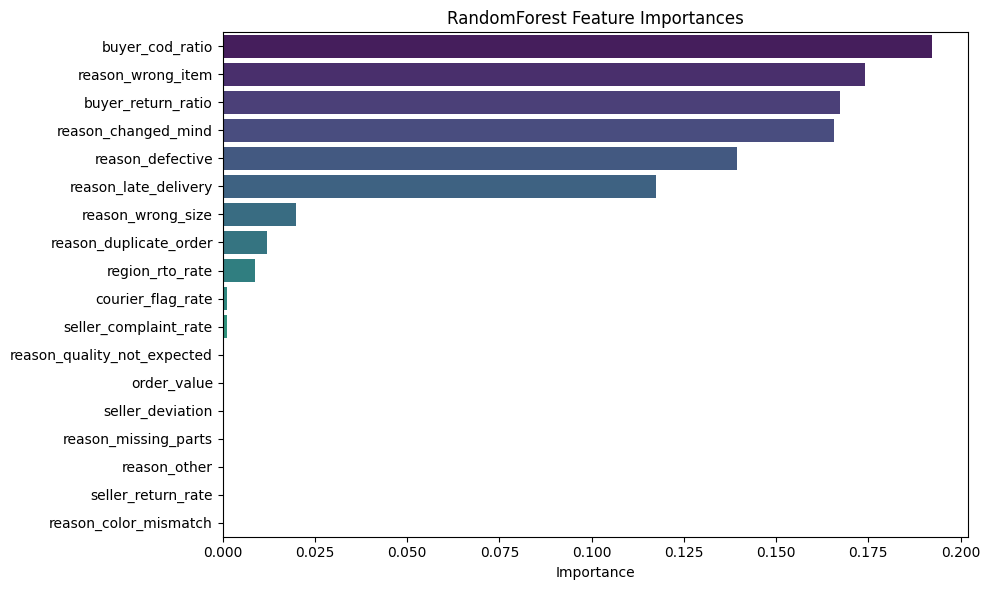

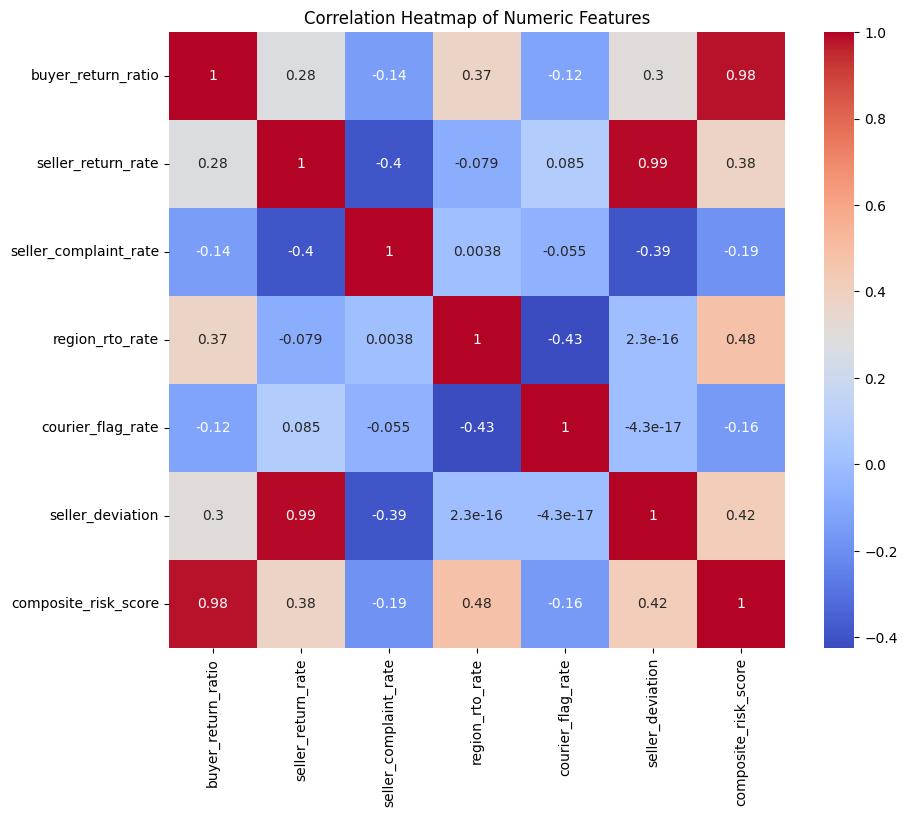

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

os.makedirs('results', exist_ok=True)

# Load datasets
consolidated_df = pd.read_csv('data/consolidated_train_dataset.csv')
buyer_df = pd.read_csv('data/buyer_features.csv')
seller_df = pd.read_csv('data/seller_features.csv')
region_df = pd.read_csv('data/region_features.csv')

# --- Pie charts for Risk Category Distribution ---

# 1. Buyers risk categories
plt.figure(figsize=(6,6))
buyer_df['risk_category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'salmon'])
plt.title('Buyer Risk Category Distribution')
plt.ylabel('')
plt.savefig('results/buyer_risk_category_distribution.png')
plt.show()

# 2. Sellers risk proxy - based on seller return rate bins
seller_df['risk_level'] = pd.qcut(seller_df['seller_return_rate'], q=3, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(6,6))
seller_df['risk_level'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'gold', 'tomato'])
plt.title('Seller Return Rate Risk Distribution')
plt.ylabel('')
plt.savefig('results/seller_risk_distribution.png')
plt.show()

# 3. Regions risk proxy - based on region RTO rate bins

# Sort regions by region_rto_rate descending
region_df = region_df.sort_values('region_rto_rate', ascending=False).reset_index(drop=True)

# Assign risk levels: top 1 -> High, next 1 -> Medium, remaining 2 -> Low
risk_levels = ['High', 'Medium'] + ['Low'] * (len(region_df) - 2)
region_df['risk_level'] = risk_levels

# Now plot using this risk_level column (pie chart)
plt.figure(figsize=(6,6))
region_df['risk_level'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['tomato', 'gold', 'lightblue'])
plt.title('Region RTO Rate Risk Distribution')
plt.ylabel('')
plt.savefig('results/region_risk_distribution.png')
plt.show()


# --- Average Frequencies of Return Reasons (Buyer) ---
reason_cols = [c for c in buyer_df.columns if c.startswith('reason_')]
mean_reasons = buyer_df[reason_cols].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=mean_reasons.values, y=mean_reasons.index, palette='Blues_r')
plt.xlabel('Average Frequency')
plt.title('Average Return Reason Frequencies (Buyers)')
plt.savefig('results/average_return_reason_frequencies.png')
plt.show()

# --- RandomForest Feature Importances ---

exclude_cols = ['buyer_id', 'seller', 'region', 'risk_category', 'fraud_label', 'composite_risk_score']
feature_cols = [c for c in consolidated_df.columns if c not in exclude_cols]

X = consolidated_df[feature_cols]
y = consolidated_df['fraud_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = rf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=[feature_cols[i] for i in indices], palette='viridis')
plt.title('RandomForest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('results/feature_importance.png')
plt.show()


# 3. Correlation heatmap

# Select numeric features for correlation
numeric_cols = [
    'buyer_return_ratio', 'seller_return_rate', 'seller_complaint_rate', 
    'region_rto_rate', 'courier_flag_rate', 'seller_deviation', 'composite_risk_score'
]

plt.figure(figsize=(10,8))
sns.heatmap(consolidated_df[numeric_cols].corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.savefig('results/feature_correlation_heatmap.png')
plt.show()



#### TEST

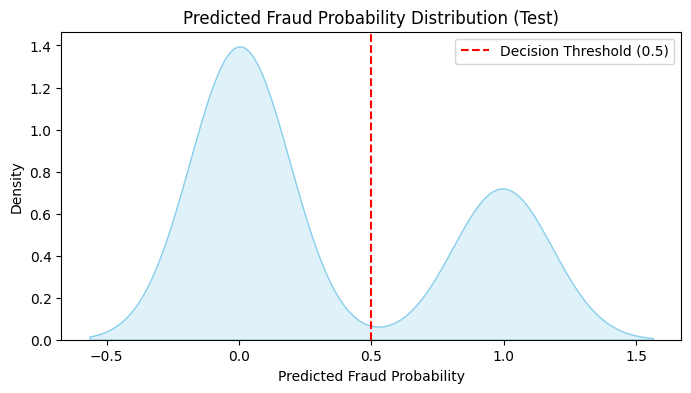

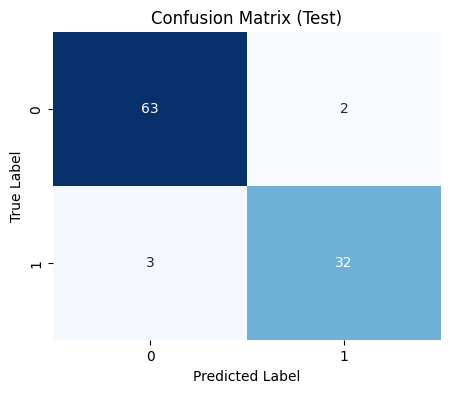

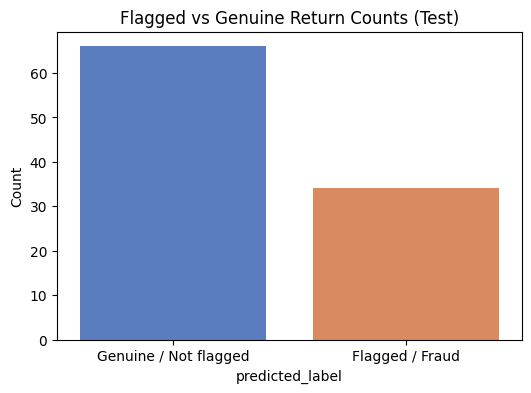

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

os.makedirs('results', exist_ok=True)

# Load test data with predictions
test_df = pd.read_csv('results/test_predictions.csv')

# 1. Predicted risk probability distribution
plt.figure(figsize=(8,4))
sns.kdeplot(test_df['predicted_proba'], shade=True, color='skyblue')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.title('Predicted Fraud Probability Distribution (Test)')
plt.xlabel('Predicted Fraud Probability')
plt.legend()
plt.savefig('results/test_predicted_probability_distribution.png')
plt.show()

# 2. Confusion matrix heatmap (requires true labels)
if 'fraud_label' in test_df.columns:
    cm = confusion_matrix(test_df['fraud_label'], test_df['predicted_label'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test)')
    plt.savefig('results/test_confusion_matrix.png')
    plt.show()

# 3. Flagged (predicted fraud) vs Genuine counts bar chart
counts = test_df['predicted_label'].value_counts().rename({0:'Genuine / Not flagged', 1:'Flagged / Fraud'})
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette='muted')
plt.title('Flagged vs Genuine Return Counts (Test)')
plt.ylabel('Count')
plt.savefig('results/test_flagged_vs_genuine_counts.png')
plt.show()
